In [58]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
import scipy.stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, brier_score_loss
from xgboost import XGBClassifier
import xgboost as xgb
import json

In [59]:
aapl = yf.download("AAPL", start="2005-01-01", group_by="column", auto_adjust=False)


[*********************100%***********************]  1 of 1 completed


In [60]:
aapl.columns = aapl.columns.get_level_values(0)
print(aapl.columns)
aapl.tail()


Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2025-11-06,269.508728,269.769989,273.399994,267.890015,267.890015,51204000
2025-11-07,268.209991,268.470001,272.290009,266.769989,269.799988,48227400
2025-11-10,269.429993,269.429993,273.730011,267.459991,268.959991,41312400
2025-11-11,275.250000,275.250000,275.910004,269.799988,269.809998,46208300
2025-11-12,273.470001,273.470001,275.730011,271.869995,275.075012,48058755


In [61]:
aapl["logreturn"] = np.log(aapl["Adj Close"]).diff()
aapl

Price,Adj Close,Close,High,Low,Open,Volume,logreturn
Date,,,,,,,
2005-01-03,0.949067,1.130179,1.162679,1.117857,1.156786,691992000,NaN
2005-01-04,0.958814,1.141786,1.169107,1.124464,1.139107,1096810400,0.010218
2005-01-05,0.967211,1.151786,1.165179,1.143750,1.151071,680433600,0.008720
2005-01-06,0.967961,1.152679,1.159107,1.130893,1.154821,705555200,0.000775
2005-01-07,1.038440,1.236607,1.243393,1.156250,1.160714,2227450400,0.070283
...,...,...,...,...,...,...,...
2025-11-06,269.508728,269.769989,273.399994,267.890015,267.890015,51204000,-0.001371
2025-11-07,268.209991,268.470001,272.290009,266.769989,269.799988,48227400,-0.004831
2025-11-10,269.429993,269.429993,273.730011,267.459991,268.959991,41312400,0.004538


In [62]:
print(aapl["logreturn"].mean(), aapl["logreturn"].std())


0.001078961338950425 0.020308823880594816


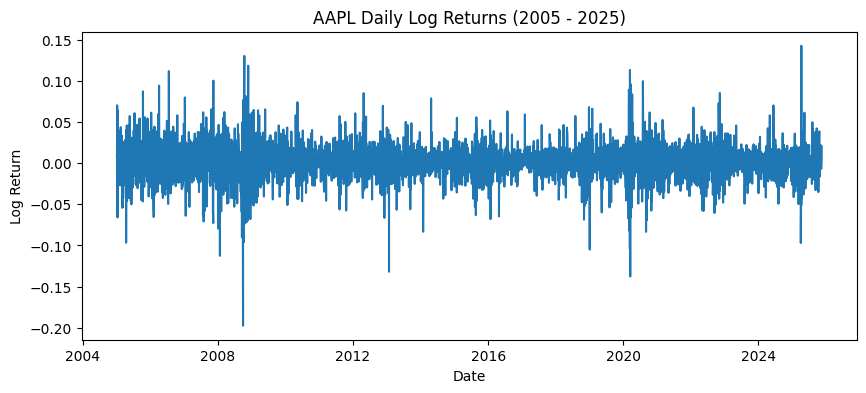

In [63]:
plt.figure(figsize=(10,4))
plt.plot(aapl.index, aapl["logreturn"])
plt.title("AAPL Daily Log Returns (2005 - 2025)")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.show()

In [64]:
r = aapl["logreturn"]

# data checks
checks = {}

checks["n_total"] = r.size
checks["n_null"] = r.isna().sum()
checks["n_posinf"] = np.isposinf(r.fillna(np.inf)).sum()
checks["n_neginf"] = np.isneginf(r.fillna(-np.inf)).sum()

idx = aapl.index
checks["index_is_datetime"] = isinstance(idx, pd.DatetimeIndex)
checks["index_is_monotic_increasing"] = idx.is_monotonic_increasing
checks["n_duplicates_in_index"] = idx.duplicated().sum()

checks["min"] = r.min(skipna=True)
checks["max"] = r.max(skipna=True)

checks
r = aapl["logreturn"].dropna()


In [65]:
# mean and velocity of aaple

r = aapl["logreturn"].dropna()
mean_daily = r.mean()
std_daily = r.std(ddof=1)

mean_daily, std_daily

(np.float64(0.001078961338950425), np.float64(0.020308823880594816))

In [66]:
# Sharpe

NUMBER_OF_TRADING_DAYS = 252

ann_mean_log = mean_daily * NUMBER_OF_TRADING_DAYS
ann_vol = std_daily * (NUMBER_OF_TRADING_DAYS ** 0.5)
sharpe = ann_mean_log / ann_vol

ann_simple = np.exp(ann_mean_log) - 1
ann_mean_log, ann_simple, ann_vol, sharpe

(np.float64(0.2718982574155071),
 np.float64(0.31245346211065006),
 np.float64(0.32239258444958163),
 np.float64(0.8433762764106901))

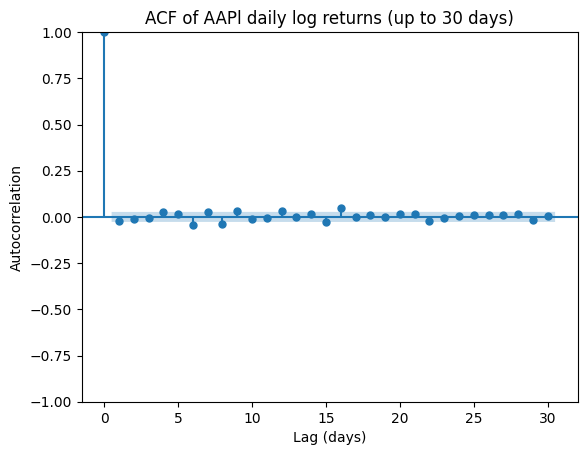

In [67]:
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt

plot_acf(r, lags=30)
plt.title("ACF of AAPl daily log returns (up to 30 days)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.show()



We see from this plot that today's return has no meaningful linear relationship with yesterday's, or with any day up to a month back
First bar is 1 since it's just the correlation of the series with itself
No momentum, so just because Apple was up yesterday, we can't conclude to buy today

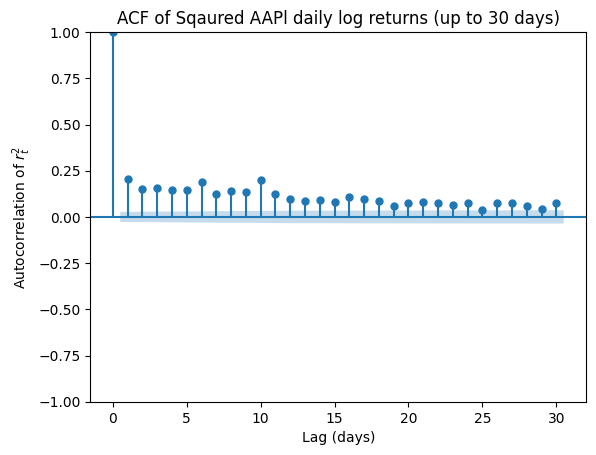

In [68]:
r2 = r ** 2

plot_acf(r2, lags=30)
plt.title("ACF of Sqaured AAPl daily log returns (up to 30 days)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation of $r_t^2$")
plt.show()

The bars are positive and significant, so when a market has a large/small swing today (up or down since it's squared), it's more likely that tomorrow will also have a large/small swing, but we can't predict which direction the swing will be in. 


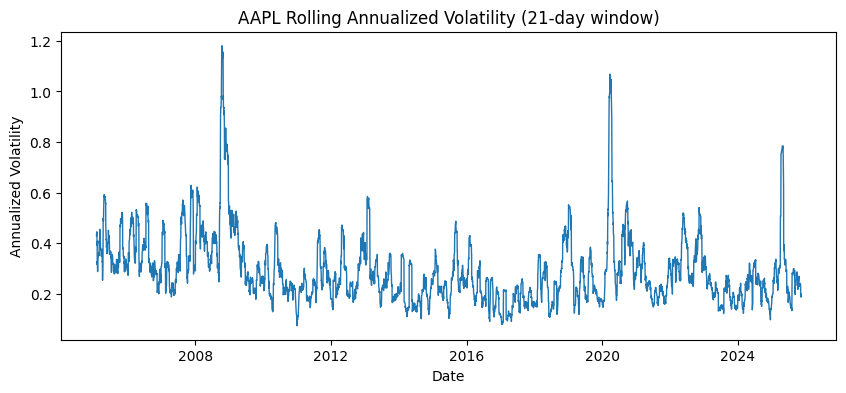

0.2583050223207452

In [69]:
import numpy as np

window = 21
roll_vol_ann = r.rolling(window).std(ddof=1) * np.sqrt(NUMBER_OF_TRADING_DAYS)

plt.figure(figsize=(10,4))
plt.plot(roll_vol_ann, linewidth=1)
plt.title(f"AAPL Rolling Annualized Volatility ({window}-day window)")
plt.ylabel("Annualized Volatility")
plt.xlabel("Date")
plt.show()

roll_vol_median = roll_vol_ann.median()
float(roll_vol_median)


The line is the estimated volatility for each day using only the previous 21 days, without peeking ahead.
Spikes represent turbulent regions, and troughs are calm regions.

25.85% is the median annualized volume across the sample

This shows when risk was high/low and how quickly it changes.



In [70]:
# fit t-GARCH(1,1) 
import arch
from arch import arch_model

r_pct = 100 * r
r_pct.head()

am = arch_model(
    r_pct,
    mean="Constant",
    vol="Garch",
    p=1, q=1,
    dist="t"
)

result = am.fit(update_freq=10, disp="off")
print(result.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                    logreturn   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -10378.2
Distribution:      Standardized Student's t   AIC:                           20766.4
Method:                  Maximum Likelihood   BIC:                           20799.2
                                              No. Observations:                 5249
Date:                      Wed, Nov 12 2025   Df Residuals:                     5248
Time:                              21:10:07   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

We see that a + b is very close to 1, so there is long-lasting volatility

In [71]:
# get residuals
resid = result.resid
sigma = result.conditional_volatility # pred std dev per day
std_resid = resid / sigma # should be student-t, iid

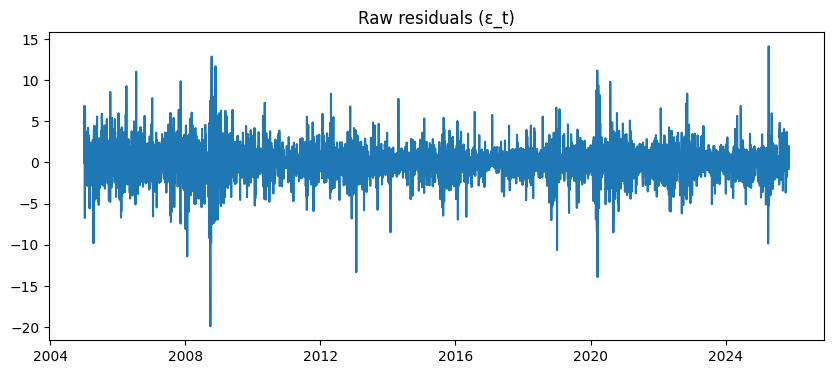

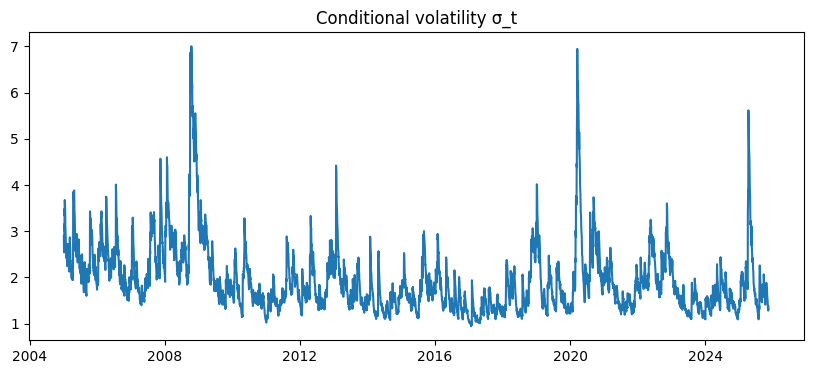

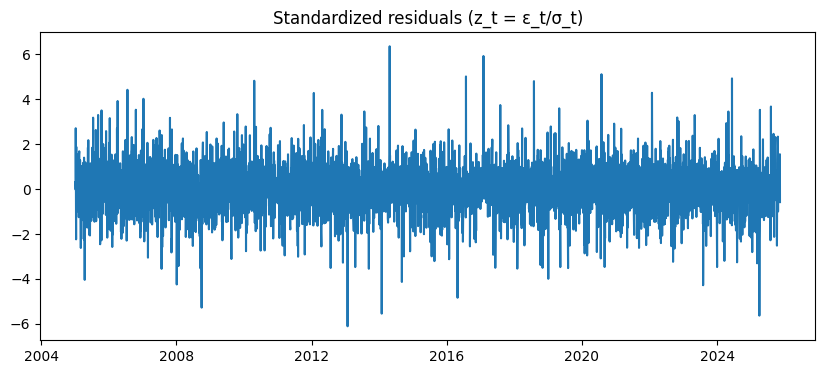

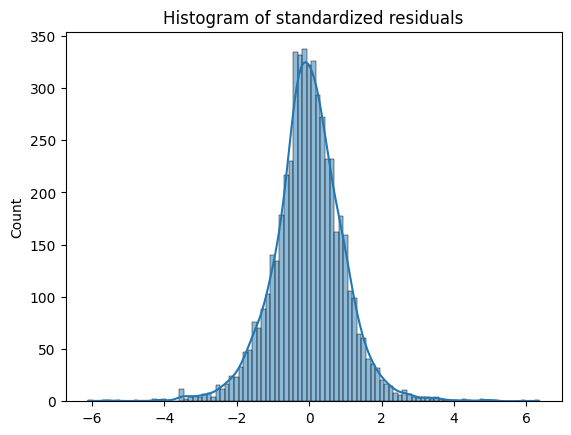

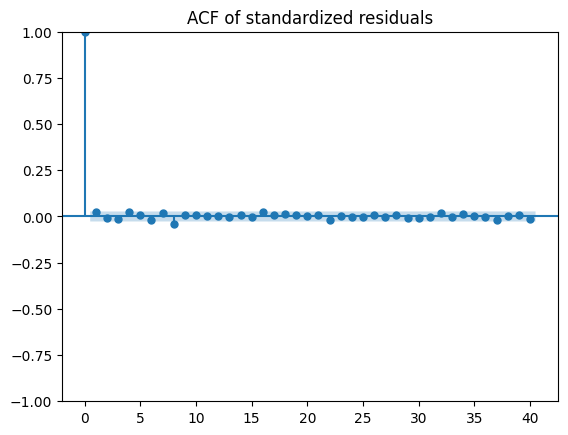

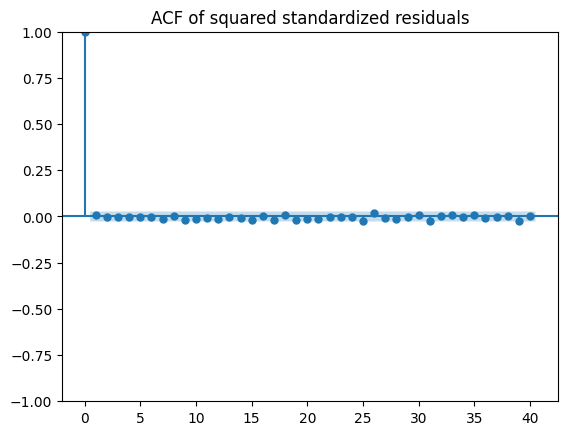

In [72]:
#visualize

plt.figure(figsize=(10,4))
plt.plot(resid)
plt.title("Raw residuals (ε_t)")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(sigma)
plt.title("Conditional volatility σ_t")
plt.show()


plt.figure(figsize=(10,4))
plt.plot(std_resid)
plt.title("Standardized residuals (z_t = ε_t/σ_t)")
plt.show()

sns.histplot(std_resid, kde=True)
plt.title("Histogram of standardized residuals")
plt.show()

plot_acf(std_resid, lags=40)
plt.title("ACF of standardized residuals")
plt.show()

plot_acf(std_resid**2, lags=40)
plt.title("ACF of squared standardized residuals")
plt.show()


In [73]:
# Ljung-Box Test: are the residuals autocorrelated, if past values help predict current ones

lb_resid = acorr_ljungbox(std_resid, lags=[10,20], return_df=True)

lb_sqresid = acorr_ljungbox(std_resid**2, lags=[10,20], return_df=True)

print("Ljunb-Box test on standardized residuals:")
print(lb_resid)
print("\nLB test on squared standardized residuals:")
print(lb_sqresid)


Ljunb-Box test on standardized residuals:
      lb_stat  lb_pvalue
10  20.661461   0.023582
20  26.039559   0.164509

LB test on squared standardized residuals:
      lb_stat  lb_pvalue
10   4.876287   0.899287
20  14.229543   0.818669


Any short-term corerlation that exists is small and dies off quickly.

From the sqaured, we see that they are completley random, since the null hypothesis was no autocorrelation, so no leftover volatility dependence. 

In [74]:
# Arch-LM Test
# do large shocks still tend to follow each other

arch_test = het_arch(std_resid)
print("ARCH-LM test results:")
print(f"LM stat = {arch_test[0]:.4f}, p-value = {arch_test[1]:.4f}")


ARCH-LM test results:
LM stat = 5.0240, p-value = 0.8896


No ARCH effects left, so the volatility model is good, volatility is fully captured.

In [75]:
# Forecast

forecasts = result.forecast(horizon=100)
forecast_var = forecasts.variance[-1:].T
forecast_var

Date,2025-11-12
h.001,1.826218
h.002,1.871382
h.003,1.916044
h.004,1.960208
h.005,2.003881
...,...
h.096,4.482762
h.097,4.498357
h.098,4.513779
h.099,4.529029


This is the model's expected condtiional variance for that next day, given what it knows. They are measures of uncertainity, so how risky the market will be each day
Right now, the model believes that the volatility is slightly below its long run level, so it is creeping upward

In [76]:
p = result.params
omega = p['omega']
alpha = p['alpha[1]']
beta  = p['beta[1]']

long_run_var = omega / (1 - alpha - beta)
long_run_vol = long_run_var**0.5
ann_vol = long_run_vol * (252**0.5)

print(f"Long-run variance: {long_run_var:.4f}")
print(f"Long-run daily vol: {long_run_vol:.2f}%")
print(f"Long-run annualized vol: {ann_vol:.2f}%")


Long-run variance: 5.8839
Long-run daily vol: 2.43%
Long-run annualized vol: 38.51%


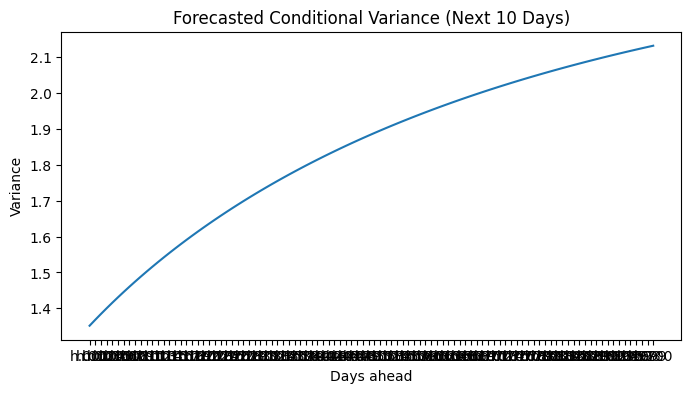

In [77]:
# Visualize future risk levels

plt.figure(figsize=(8,4))
plt.plot(forecast_var**0.5)
plt.title("Forecasted Conditional Variance (Next 10 Days)")
plt.xlabel("Days ahead")
plt.ylabel("Variance")
plt.show()

In [78]:



mu = float(result.params['mu'])          # mean (%/day)
nu = float(result.params['nu'])          # t degrees of freedom


forecasts = result.forecast(horizon=1)
var_t1 = float(result.forecast(horizon=1).variance.iloc[-1, 0])   # variance for h.01 (percent^2/day)
sigma_t1 = np.sqrt(var_t1)                        # volatility for h.01 (percent/day)

# confidence levels#
levels = {'VaR95': 0.05, 'VaR99': 0.01}


out = {}
for name, alpha in levels.items():
    q = st.t.ppf(alpha, df=nu)                   # negative number
    var_return = mu + sigma_t1 * q               # in percent
    var_loss   = -var_return                      # loss convention (positive)
    out[name] = {'return_VaR_%': var_return, 'loss_VaR_%': var_loss}

out, mu, sigma_t1, nu


({'VaR95': {'return_VaR_%': np.float64(-2.59743079366633),
   'loss_VaR_%': np.float64(2.59743079366633)},
  'VaR99': {'return_VaR_%': np.float64(-4.47728809729255),
   'loss_VaR_%': np.float64(4.47728809729255)}},
 0.15120423125061638,
 np.float64(1.351376262169913),
 4.79787861205477)

There is a 5% chance the loss exceeds 2.689%

In [79]:
# Multi day VaR

horizon = 10
alpha = 0.05
forecasts = result.forecast(horizon=horizon)
vars_horizon = forecasts.variance.iloc[-1].values # each days forecast var from model
sigma_h = np.sqrt(np.sum(vars_horizon))  # 10 day forecased volatility

# student t quantile
q = st.t.ppf(alpha,df=nu)

# multi day
var_horizon_return = mu*horizon + sigma_h*q # expected h-day return quantile 
var_horizon_loss = -var_horizon_return


print(f"{horizon}-day 95% VaR (return): {var_horizon_return:.2f}%")
print(f"{horizon}-day 95% VaR (loss):   {var_horizon_loss:.2f}%")


10-day 95% VaR (return): -7.64%
10-day 95% VaR (loss):   7.64%


There is a 7% chance over the next 10 trading thats that the total loss will exceed 7.9%.

In [80]:
# Expected Shortfall
# If worst a% days happen, how bad are they on average? 
# mean loss beyond VaR


alpha = 0.05 # 94% ES
q = st.t.ppf(alpha, df=nu)
pdf = st.t.pdf(q,df=nu)

multiplier = (nu + q**2) / ((nu - 1) * alpha) * pdf

es_return = mu - sigma_t1 * multiplier
es_loss = -es_return


print(f"1-day 95% ES (return): {es_return:.2f}%")
print(f"1-day 95% ES (loss):   {es_loss:.2f}%")



1-day 95% ES (return): -3.82%
1-day 95% ES (loss):   3.82%


We see that if tomorrow is included in the worst 5% of days, the average loss is about 1.19%

In [81]:
# Test 1-day Var to check if model matches reality
# Do x% of days break the 95%VaR and do they happen iid

alpha = 0.05
history = 1000
rets = r_pct.loc['2020-01-01':].dropna()
dates = rets.index
returns = rets.values

VaR_pred = []
actual = []

for t in range(history, len(returns)-1):
    #fit the model up to day t
    y = pd.Series(rets[t-history:t], index=dates[t-history:t])
    am = arch_model(y, mean="Constant", vol="Garch", p=1, q=1, dist="t")
    fitted = am.fit(disp="off")

    # params and forecast next-day variance
    mu = float(fitted.params['mu'])
    nu = float(fitted.params['nu'])
    var_next = float(fitted.forecast(horizon=1).variance.iloc[-1,0])
    sigma_next = np.sqrt(var_next)

    # computer 1-dat VaR
    q = st.t.ppf(alpha, df=nu)
    VaR_next = mu + sigma_next*q
    VaR_pred.append(VaR_next)

    actual.append(returns[t+1])

backtest = pd.DataFrame({
    "Date": dates[history+1:],
    "Return": actual,
    "VaR": VaR_pred
}).set_index("Date")

# check when they exceed

backtest["Exceed"] = (backtest["Return"] < backtest["VaR"]).astype(int)
backtest.head()




,Return,VaR,Exceed
Date,,,
2023-12-22,-0.556272,-2.151567,0
2023-12-26,-0.284507,-2.084675,0
2023-12-27,0.051800,-2.056848,0
2023-12-28,0.222363,-2.002874,0
2023-12-29,-0.543880,-1.934497,0


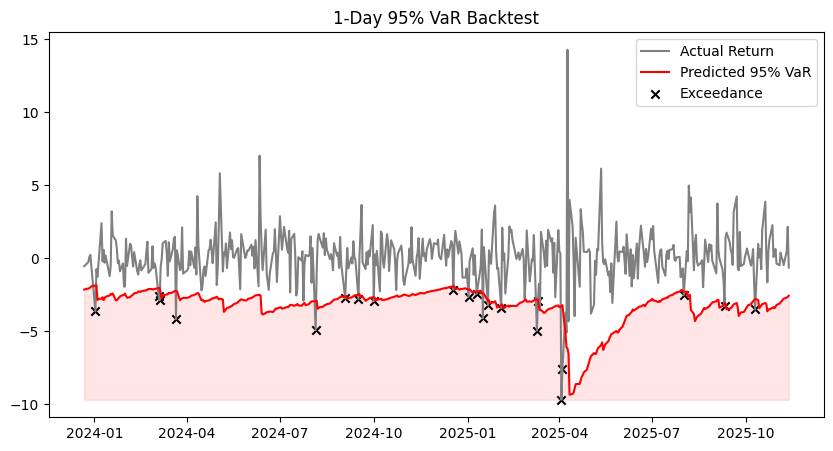

In [82]:
plt.figure(figsize=(10,5))
plt.plot(backtest["Return"], label="Actual Return", color="gray")
plt.plot(backtest["VaR"], label="Predicted 95% VaR", color="red")
plt.fill_between(backtest.index, backtest["VaR"], min(backtest["Return"]), color="red", alpha=0.1)
plt.scatter(backtest.index[backtest["Exceed"]==1], backtest["Return"][backtest["Exceed"]==1],
            color="black", marker="x", label="Exceedance")
plt.legend(); plt.title("1-Day 95% VaR Backtest"); plt.show()

In [83]:
# Frequency (Kupiec Test)

n = len(backtest)
x = backtest["Exceed"].sum()
p_hat = x / n
LR_uc = -2 * ((n - x) * np.log((1 - alpha) / (1 - p_hat)) + x * np.log(alpha / p_hat) )
p_uc = 1 - st.chi2.cdf(LR_uc, df=1)


print(f"Exceedances {x}/{n} = {p_hat:.2%}, Kupiec p-value = {p_uc:.3f}")

Exceedances 21/474 = 4.43%, Kupiec p-value = 0.562


From here we see that the model overestimates risk.

In [84]:
import numpy as np, pandas as pd, scipy.stats as st
from arch import arch_model

alpha = 0.05
window = 750                 # ~3y; use 500 for faster response
series = r_pct.loc['2020-01-01':].dropna()
dates, rets = series.index, series.values

VaR, realized = [], []
for t in range(window, len(rets)-1):
    y = pd.Series(rets[t-window:t], index=dates[t-window:t])
    am = arch_model(y, mean="Constant", vol="Garch", p=1, q=1, dist="t")
    res = am.fit(disp="off")
    mu, nu = float(res.params['mu']), float(res.params['nu'])
    sig1 = float(res.forecast(horizon=1).variance.iloc[-1,0])**0.5
    q = st.t.ppf(alpha, df=nu)
    VaR.append(mu + sig1*q)           # return VaR (%)
    realized.append(rets[t+1])

bt = pd.DataFrame({"Return": realized, "VaR": VaR}, index=dates[window+1:])
bt["Exceed"] = (bt["Return"] <= bt["VaR"]).astype(int)

# Kupiec
n, x = len(bt), int(bt["Exceed"].sum())
p_hat = x/n
LR_uc = -2*np.log(((1-alpha)**(n-x)*alpha**x)/((1-p_hat)**(n-x)*p_hat**x))
p_uc = 1 - st.chi2.cdf(LR_uc, 1)
print(f"POST-2020 95% VaR: breaches {x}/{n} = {p_hat:.2%}, Kupiec p={p_uc:.3f}")


POST-2020 95% VaR: breaches 26/724 = 3.59%, Kupiec p=0.068


In [85]:
# Check if these happen independently or clustered

# Indicator Array
# I[t] = 1 : VaR breach happened on day t
I = bt["Exceed"].astype(int).values

# check consectuvie positions
I_prev = I[:-1]
I_next = I[1:]

n00 = np.sum((I_prev == 0) & (I_next == 0))
n01 = np.sum((I_prev == 0) & (I_next == 1))
n10 = np.sum((I_prev == 1) & (I_next == 0))
n11 = np.sum((I_prev == 1) & (I_next == 1))

# Compute probabilities

den0 = n00 + n01
den1 = n10 + n11

if den0 > 0:
    pi0 = n01 / den0
else:
    pi0 = 0

if den1 > 0:
    pi1 = n11 / den1
else:
    pi1 = 0


if (den0 + den1) > 0:
    pi = (n01 + n11) / (den0 + den1)
else:
    pi = 0

pi0, pi1, pi



(np.float64(0.03156384505021521),
 np.float64(0.15384615384615385),
 np.float64(0.035961272475795295))

In [86]:
eps = 1e-12
pi0c = min(max(pi0, eps), 1-eps)
pi1c = min(max(pi1, eps), 1-eps)
pic = min(max(pi, eps), 1-eps)

# Check likelihood
L_ind = ((1 - pi0c)**n00) * (pi0c**n01) * ((1-pi1c)**n10) * (pi1c**n11)
L_poi = ((1 - pic)**(n00 + n10)) * (pic**(n01 + n11))

LR_ind = -2 * np.log(L_poi / L_ind)
p_ind = 1 - st.chi2.cdf(LR_ind, df=1)
LR_ind, p_ind


(np.float64(6.29419354940511), np.float64(0.012113411693885023))

So after one VaR breach, another one is much more likely and not independant. The model is too slow to adapt when volatility jumps

In [125]:
# === DIAGNOSTIC: What's going wrong? ===

import numpy as np, pandas as pd, scipy.stats as st
from arch import arch_model
import matplotlib.pyplot as plt

alpha = 0.05
window = 750
series = r_pct.loc['2020-01-01':].dropna()
dates, rets = series.index, series.values

print(f"Data info:")
print(f"  Start date: {dates[0]}")
print(f"  End date: {dates[-1]}")
print(f"  Total observations: {len(rets)}")
print(f"  Mean return: {rets.mean():.4f}%")
print(f"  Std return: {rets.std():.4f}%")
print(f"  Min return: {rets.min():.4f}%")
print(f"  Max return: {rets.max():.4f}%")

# Test a single GARCH fit
print("\n" + "="*60)
print("Testing single GARCH fit...")
y_test = pd.Series(rets[:window], index=dates[:window])
am_test = arch_model(y_test, mean="Constant", vol="GARCH", p=1, q=1, dist="t")
res_test = am_test.fit(disp="off")

print(res_test.summary())
print(f"\nConvergence: {res_test.convergence_flag}")
print(f"Params: {dict(res_test.params)}")

# Forecast
forecast = res_test.forecast(horizon=1)
var_forecast = float(forecast.variance.iloc[-1, 0])
sig_forecast = np.sqrt(var_forecast)
mu = float(res_test.params['mu'])
nu = float(res_test.params['nu'])
q = st.t.ppf(alpha, df=nu)
var_estimate = mu + sig_forecast * q

print(f"\nForecast for next day:")
print(f"  Mean (mu): {mu:.4f}%")
print(f"  Volatility (sigma): {sig_forecast:.4f}%")
print(f"  t df (nu): {nu:.2f}")
print(f"  VaR(5%): {var_estimate:.4f}%")
print(f"  Actual next return: {rets[window]:.4f}%")
print(f"  Breach? {rets[window] <= var_estimate}")

Data info:
  Start date: 2020-01-02 00:00:00
  End date: 2025-11-12 00:00:00
  Total observations: 1475
  Mean return: 0.0916%
  Std return: 2.0171%
  Min return: -13.7708%
  Max return: 14.2617%

Testing single GARCH fit...
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1605.81
Distribution:      Standardized Student's t   AIC:                           3221.61
Method:                  Maximum Likelihood   BIC:                           3244.72
                                              No. Observations:                  750
Date:                      Wed, Nov 12 2025   Df Residuals:                      749
Time:                              21:30:20   Df Model:                            1
          

In [126]:
# === Check if r_pct is correct ===

print("\nr_pct info:")
print(r_pct.head())
print(f"\nIs it in PERCENT? (should be ~0.1 to 3, not 0.001 to 0.03)")
print(f"Mean: {r_pct.mean():.4f}")
print(f"Std: {r_pct.std():.4f}")

# If your data is in decimal (0.01 = 1%), you need to multiply by 100
if abs(r_pct.mean()) < 0.1:
    print("\n⚠️  WARNING: Your data looks like it's in decimal, not percent!")
    print("   You should use: r_pct = 100 * r")


r_pct info:
Date
2005-01-04    1.021768
2005-01-05    0.872035
2005-01-06    0.077507
2005-01-07    7.028261
2005-01-10   -0.419634
Name: logreturn, dtype: float64

Is it in PERCENT? (should be ~0.1 to 3, not 0.001 to 0.03)
Mean: 0.1079
Std: 2.0309


In [127]:
# === Minimal backtest with detailed logging ===

alpha = 0.05
window = 750
series = r_pct.loc['2020-01-01':].dropna()
dates, rets = series.index, series.values

VaR_list = []
realized_list = []
dates_list = []

# Just do first 10 iterations with detailed output
max_iters = min(10, len(rets) - window - 1)

for i, t in enumerate(range(window, window + max_iters)):
    print(f"\n--- Iteration {i+1}/{max_iters} (day {t}) ---")
    
    # Training data
    y = pd.Series(rets[t-window:t], index=dates[t-window:t])
    print(f"Train period: {y.index[0]} to {y.index[-1]}")
    print(f"Train stats: mean={y.mean():.3f}, std={y.std():.3f}")
    
    # Fit
    am = arch_model(y, mean="Constant", vol="GARCH", p=1, q=1, dist="t")
    try:
        res = am.fit(disp="off")
        print(f"Converged: {res.convergence_flag}")
        
        if not res.convergence_flag:
            print("⚠️  Did not converge, skipping...")
            continue
        
        # Extract parameters
        mu = float(res.params['mu'])
        nu = float(res.params['nu'])
        sig1 = float(res.forecast(horizon=1).variance.iloc[-1, 0])**0.5
        q = st.t.ppf(alpha, df=nu)
        
        var_est = mu + sig1 * q
        actual = rets[t+1]
        
        print(f"Params: mu={mu:.3f}, sigma={sig1:.3f}, nu={nu:.2f}")
        print(f"VaR(5%) = {var_est:.3f}")
        print(f"Actual = {actual:.3f}")
        print(f"Breach? {actual <= var_est}")
        
        VaR_list.append(var_est)
        realized_list.append(actual)
        dates_list.append(dates[t+1])
        
    except Exception as e:
        print(f"❌ Error: {e}")
        continue

print("\n" + "="*60)
print("Summary of first 10 forecasts:")
print(f"VaR range: [{min(VaR_list):.3f}, {max(VaR_list):.3f}]")
print(f"Return range: [{min(realized_list):.3f}, {max(realized_list):.3f}]")
print(f"Breaches: {sum(1 for r, v in zip(realized_list, VaR_list) if r <= v)}/{len(VaR_list)}")


--- Iteration 1/10 (day 750) ---
Train period: 2020-01-02 00:00:00 to 2022-12-21 00:00:00
Train stats: mean=0.084, std=2.327
Converged: 0
⚠️  Did not converge, skipping...

--- Iteration 2/10 (day 751) ---
Train period: 2020-01-03 00:00:00 to 2022-12-22 00:00:00
Train stats: mean=0.078, std=2.328
Converged: 0
⚠️  Did not converge, skipping...

--- Iteration 3/10 (day 752) ---
Train period: 2020-01-06 00:00:00 to 2022-12-23 00:00:00
Train stats: mean=0.079, std=2.327
Converged: 0
⚠️  Did not converge, skipping...

--- Iteration 4/10 (day 753) ---
Train period: 2020-01-07 00:00:00 to 2022-12-27 00:00:00
Train stats: mean=0.076, std=2.328
Converged: 0
⚠️  Did not converge, skipping...

--- Iteration 5/10 (day 754) ---
Train period: 2020-01-08 00:00:00 to 2022-12-28 00:00:00
Train stats: mean=0.073, std=2.331
Converged: 0
⚠️  Did not converge, skipping...

--- Iteration 6/10 (day 755) ---
Train period: 2020-01-09 00:00:00 to 2022-12-29 00:00:00
Train stats: mean=0.074, std=2.332
Converged

ValueError: min() iterable argument is empty

In [155]:
# GJR-Garch model


alpha = 0.05
window = 750           
series = r_pct.loc['2022-01-01':].dropna()
dates, rets = series.index, series.values

VaR_gjr, realized_gjr, idx = [], [], []
for t in range(window, len(rets)-1):
    y = pd.Series(rets[t-window:t], index=dates[t-window:t])
    am = arch_model(y, mean="Constant", vol="Garch", p=1, q=1, o=1, dist="t")
    try:
        res = am.fit(disp="off", options={'maxiter': 2000}, show_warning=False)
        converged = getattr(res, "converged", res.convergence_flag == 0)

        if not converged:
            continue

        mu = float(res.params['mu'])
        nu = float(res.params['nu'])  
        # q = float(res.distribution.ppf(alpha))
        sig1 = float(res.forecast(horizon=1).variance.iloc[-1,0])**0.5
        q = st.t.ppf(alpha, df=nu)
        VaR_gjr.append(mu + sig1*q)          
        realized_gjr.append(rets[t+1])
        idx.append(dates[t+1])
    except Exception as e:
        continue

bt_gjr = pd.DataFrame({"Return": realized_gjr, "VaR": VaR_gjr}, index=idx)
bt_gjr["Exceed"] = (bt_gjr["Return"] <= bt_gjr["VaR"]).astype(int)

# Kupiec
n, x = len(bt_gjr), int(bt_gjr["Exceed"].sum())
p_hat = x/n
LR_uc = -2*np.log(((1-alpha)**(n-x)*alpha**x)/((1-p_hat)**(n-x)*p_hat**x))
p_uc = 1 - st.chi2.cdf(LR_uc, 1)
print(f"POST-2020 95% VaR: breaches {x}/{n} = {p_hat:.2%}, Kupiec p={p_uc:.3f}")


POST-2020 95% VaR: breaches 9/219 = 4.11%, Kupiec p=0.533


In [156]:
I = bt_gjr["Exceed"].astype(int).values
n = len(I)
x = I.sum()

if n > 0:
    p_hat = x / n
else:
    p_hat = 0

LR_uc = -2 * ((n - x) * np.log((1 - alpha) / (1 - p_hat)) + x * np.log(alpha / p_hat) )
p_uc = 1 - st.chi2.cdf(LR_uc, df=1)


In [157]:
# Independance Test
I_prev = I[:-1]
I_next = I[1:]

n00 = np.sum((I_prev == 0) & (I_next == 0))
n01 = np.sum((I_prev == 0) & (I_next == 1))
n10 = np.sum((I_prev == 1) & (I_next == 0))
n11 = np.sum((I_prev == 1) & (I_next == 1))


den0 = n00 + n01
den1 = n10 + n11

if den0 > 0:
    pi0 = n01 / den0
else:
    pi0 = 0

if den1 > 0:
    pi1 = n11 / den1
else:
    pi1 = 0


if (den0 + den1) > 0:
    pi = (n01 + n11) / (den0 + den1)
else:
    pi = 0

pi0, pi1, pi

eps = 1e-12
pi0c = min(max(pi0, eps), 1-eps)
pi1c = min(max(pi1, eps), 1-eps)
pic = min(max(pi, eps), 1-eps)

# Check likelihood
L_ind = ((1 - pi0c)**n00) * (pi0c**n01) * ((1-pi1c)**n10) * (pi1c**n11)
L_poi = ((1 - pic)**(n00 + n10)) * (pic**(n01 + n11))

LR_ind = -2 * np.log(L_poi / L_ind)
p_ind = 1 - st.chi2.cdf(LR_ind, df=1)


LR_cc = LR_uc + LR_ind
p_cc = 1 - st.chi2.cdf(LR_cc, df=2)


print(f"GJR-GARCH VaR95 — breaches {x}/{n} = {p_hat:.2%}")
print(f"  Kupiec  (UC):   LR={LR_uc:.3f}, p={p_uc:.3f}")
print(f"  Indep.  (IND):  pi0={pi0:.3f}, pi1={pi1:.3f} | LR={LR_ind:.3f}, p={p_ind:.3f}")
print(f"  CondCov (CC):   LR={LR_cc:.3f}, p={p_cc:.3f}")




GJR-GARCH VaR95 — breaches 9/219 = 4.11%
  Kupiec  (UC):   LR=0.388, p=0.533
  Indep.  (IND):  pi0=0.038, pi1=0.111 | LR=0.819, p=0.365
  CondCov (CC):   LR=1.207, p=0.547
